<a href="https://colab.research.google.com/github/hania-amr/Lyrics_analysis/blob/main/deepLearning_lyricsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
import nltk
from tabulate import tabulate
from IPython.core.display import display, HTML
from scipy.stats import skewnorm, gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from tqdm import tqdm
import torch
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import umap
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import logging
from torch.utils.data import DataLoader

In [5]:
data = pd.read_csv('/content/fayrouz_lyrics - Sheet1.csv')
data.head()

,Track title,track lyrics,Release Year,composer,Lyricist
0,البنت الشلبية,البنت الشلبية .. عيونا لوزية بحبك من قلبي .. ي...,2009.0,تراث,تراث
1,اخر ايام الصيفيه,آخر أيام الصيفية والصبية شوي شوي وصلت ع ساحة م...,1975.0,الأخوين رحباني,الأخوين رحباني
2,اعطني الناي,أعطني الناي وغن فالغنا سر الوجود وأنين الناي ي...,1973.0,نجيب حنكش,جبران خليل جبران
3,انا لحبيبي,أنا لحبيبي و حبيبي إلي يا عصفورة بيضا لا بقى ت...,1965.0,الأخوين رحباني,الأخوين رحباني
4,بكتب اسمك,بكتب اسمك ياحبيبي ع الحور العتيق .. بتكتب اسمي...,1961.0,الأخوين رحباني,الأخوين رحباني


In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
print(data.shape[0])
print(data.shape[1])
print(data.columns.tolist())

109
5
['Track title', 'track lyrics', 'Release Year', 'composer ', 'Lyricist']


In [8]:
before_dedup = data.shape[0]
data = data.drop_duplicates()
after_dedup = data.shape[0]

print(f"Number of songs before removing duplicates: {before_dedup}")
print(f"Number of songs after removing duplicates: {after_dedup}")
print(f"Number of duplicates removed: {before_dedup - after_dedup}")


Number of songs before removing duplicates: 109
Number of songs after removing duplicates: 105
Number of duplicates removed: 4


In [9]:
data = data.drop_duplicates(subset=['Track title', 'track lyrics'])

In [10]:
track_lyrics_df = data['track lyrics'].to_frame()
print(track_lyrics_df.head())

                                        track lyrics
0  البنت الشلبية .. عيونا لوزية بحبك من قلبي .. ي...
1  آخر أيام الصيفية والصبية شوي شوي وصلت ع ساحة م...
2  أعطني الناي وغن فالغنا سر الوجود وأنين الناي ي...
3  أنا لحبيبي و حبيبي إلي يا عصفورة بيضا لا بقى ت...
4  بكتب اسمك ياحبيبي ع الحور العتيق .. بتكتب اسمي...


In [11]:
#removing all punctuation and special characters
data['track lyrics'] = data['track lyrics'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data.head()

,Track title,track lyrics,Release Year,composer,Lyricist
0,البنت الشلبية,البنت الشلبية عيونا لوزية بحبك من قلبي ياقلب...,2009.0,تراث,تراث
1,اخر ايام الصيفيه,آخر أيام الصيفية والصبية شوي شوي وصلت ع ساحة م...,1975.0,الأخوين رحباني,الأخوين رحباني
2,اعطني الناي,أعطني الناي وغن فالغنا سر الوجود وأنين الناي ي...,1973.0,نجيب حنكش,جبران خليل جبران
3,انا لحبيبي,أنا لحبيبي و حبيبي إلي يا عصفورة بيضا لا بقى ت...,1965.0,الأخوين رحباني,الأخوين رحباني
4,بكتب اسمك,بكتب اسمك ياحبيبي ع الحور العتيق بتكتب اسمي ي...,1961.0,الأخوين رحباني,الأخوين رحباني


In [12]:
import re
import pandas as pd

# Function to strip punctuation characters
def clean_punctuation(text):
    text = str(text)
    return re.sub(r'[^\w\s]', '', text)

# Function to normalize line breaks and carriage returns
def normalize_whitespace(text):
    text = str(text)
    return text.replace('\n', ' ').replace('\r', '')

# Function to remove Arabic diacritic marks
def strip_arabic_diacritics(text):
    text = str(text)
    diacritics_pattern = re.compile(r"""
        [ًٌٍَُِّْـ~]  # Arabic vowel marks, sukun, and tatwil
    """, re.VERBOSE)
    return re.sub(diacritics_pattern, '', text)

data['track lyrics'] = data['track lyrics'].apply(clean_punctuation)
data['track lyrics'] = data['track lyrics'].apply(normalize_whitespace)
data['track lyrics'] = data['track lyrics'].apply(strip_arabic_diacritics)
data['Track title'] = data['Track title'].apply(clean_punctuation)
data['Track title'] = data['Track title'].apply(normalize_whitespace)
data['Track title'] = data['Track title'].apply(strip_arabic_diacritics)

data.head()

,Track title,track lyrics,Release Year,composer,Lyricist
0,البنت الشلبية,البنت الشلبية عيونا لوزية بحبك من قلبي ياقلب...,2009.0,تراث,تراث
1,اخر ايام الصيفيه,آخر أيام الصيفية والصبية شوي شوي وصلت ع ساحة م...,1975.0,الأخوين رحباني,الأخوين رحباني
2,اعطني الناي,أعطني الناي وغن فالغنا سر الوجود وأنين الناي ي...,1973.0,نجيب حنكش,جبران خليل جبران
3,انا لحبيبي,أنا لحبيبي و حبيبي إلي يا عصفورة بيضا لا بقى ت...,1965.0,الأخوين رحباني,الأخوين رحباني
4,بكتب اسمك,بكتب اسمك ياحبيبي ع الحور العتيق بتكتب اسمي ي...,1961.0,الأخوين رحباني,الأخوين رحباني


In [13]:
def standardizing_arabic_text(text):
    text = re.sub(r'ي\b', 'ى', text)
    text = text.replace('أ', 'ا')
    text = text.replace('آ', 'ا')
    text = re.sub(r'\bإ', 'ا', text)
    text = re.sub(r'ة\b', 'ه', text)
    return text

data['track lyrics'] = data['track lyrics'].apply(standardizing_arabic_text)
data['Track title'] = data['Track title'].apply(standardizing_arabic_text)
data['composer ']= data['composer '].apply(standardizing_arabic_text)

data.head()

,Track title,track lyrics,Release Year,composer,Lyricist
0,البنت الشلبيه,البنت الشلبيه عيونا لوزيه بحبك من قلبى ياقلب...,2009.0,تراث,تراث
1,اخر ايام الصيفيه,اخر ايام الصيفيه والصبيه شوى شوى وصلت ع ساحه م...,1975.0,الاخوين رحبانى,الأخوين رحباني
2,اعطنى الناى,اعطنى الناى وغن فالغنا سر الوجود وانين الناى ي...,1973.0,نجيب حنكش,جبران خليل جبران
3,انا لحبيبى,انا لحبيبى و حبيبى الى يا عصفوره بيضا لا بقى ت...,1965.0,الاخوين رحبانى,الأخوين رحباني
4,بكتب اسمك,بكتب اسمك ياحبيبى ع الحور العتيق بتكتب اسمى ي...,1961.0,الاخوين رحبانى,الأخوين رحباني


In [14]:
def clean_name(name):
    if isinstance(name, str):
        return ' '.join(name.strip().split())
    return name

data['composer '] = data['composer '].apply(clean_name)

In [15]:
total_words_with = data['track lyrics'].apply(lambda x: len(x.split())).sum()
print(f'number of words with stopwords: {total_words_with}')

number of words with stopwords: 7462


In [16]:
words_before = data['track lyrics'].apply(lambda x: x.split()).explode()

In [17]:
stop_words = set(stopwords.words('arabic'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

data['track lyrics'] = data['track lyrics'].apply(remove_stopwords)
data['Track title'] = data['Track title'].apply(remove_stopwords)
data.head()

,Track title,track lyrics,Release Year,composer,Lyricist
0,البنت الشلبيه,البنت الشلبيه عيونا لوزيه بحبك قلبى ياقلبى انت...,2009.0,تراث,تراث
1,اخر ايام الصيفيه,اخر ايام الصيفيه والصبيه شوى شوى وصلت ساحه ميس...,1975.0,الاخوين رحبانى,الأخوين رحباني
2,اعطنى الناى,اعطنى الناى وغن فالغنا سر الوجود وانين الناى ي...,1973.0,نجيب حنكش,جبران خليل جبران
3,انا لحبيبى,انا لحبيبى حبيبى الى عصفوره بيضا بقى تسالى يعت...,1965.0,الاخوين رحبانى,الأخوين رحباني
4,بكتب اسمك,بكتب اسمك ياحبيبى الحور العتيق بتكتب اسمى حبيب...,1961.0,الاخوين رحبانى,الأخوين رحباني


In [18]:
total_words_without = data['track lyrics'].apply(lambda x: len(x.split())).sum()
print(f'number of words after removing stopwords: {total_words_without}')

number of words after removing stopwords: 6203


In [19]:
words_after = data['track lyrics'].apply(lambda x: x.split()).explode()

In [20]:
eliminated_words = words_before[~words_before.isin(words_after)]
print(f'Total number of eliminated words: {len(eliminated_words)}')
print(f'Eliminated words: {eliminated_words.tolist()}')

Total number of eliminated words: 1259
Eliminated words: ['من', 'و', 'و', 'تحت', 'و', 'يا', 'و', 'ع', 'فيها', 'لو', 'ما', 'بعد', 'هل', 'دون', 'هل', 'من', 'من', 'هل', 'بين', 'هل', 'ما', 'ما', 'قد', 'لكن', 'و', 'يا', 'لا', 'لا', 'و', 'لا', 'و', 'راح', 'و', 'على', 'و', 'و', 'و', 'و', 'من', 'من', 'و', 'يا', 'ع', 'يا', 'ع', 'ع', 'يا', 'تحت', 'ع', 'لا', 'ولا', 'فيها', 'ما', 'ع', 'يا', 'ع', 'و', 'يا', 'و', 'على', 'يا', 'و', 'و', 'و', 'و', 'ما', 'على', 'و', 'و', 'ما', 'كان', 'ع', 'ع', 'كل', 'ما', 'كل', 'ما', 'من', 'كان', 'من', 'كان', 'سوى', 'على', 'على', 'من', 'على', 'على', 'له', 'يا', 'له', 'وما', 'ومن', 'ما', 'عشرين', 'يا', 'يا', 'ع', 'على', 'على', 'فوق', 'ع', 'كان', 'على', 'لو', 'مع', 'ها', 'بعد', 'يا', 'يا', 'يا', 'يا', 'يا', 'يا', 'يا', 'يا', 'يا', 'يا', 'يا', 'يا', 'يا', 'يا', 'و', 'يا', 'وإن', 'عليه', 'يا', 'يا', 'يا', 'منها', 'ما', 'ولا', 'من', 'كيف', 'فيها', 'على', 'و', 'بين', 'على', 'على', 'ولا', 'على', 'فيها', 'لا', 'ولا', 'هل', 'عن', 'على', 'على', 'على', 'كم', 'من', 'من', 'ما', 'و'

In [21]:
data['Tokenized & Preprocessed Lyrics'] = data['track lyrics'].apply(lambda x: x.split())
data['Tokenized & Preprocessed Lyrics'] = data['Tokenized & Preprocessed Lyrics'].apply(lambda x: '\n'.join(x))

print(data[['Track title', 'track lyrics', 'Tokenized & Preprocessed Lyrics']].head())

data.to_csv('fayrouz_lyrics_tokenized.csv', index=False, encoding='utf-8-sig')

        Track title                                       track lyrics  \
0     البنت الشلبيه  البنت الشلبيه عيونا لوزيه بحبك قلبى ياقلبى انت...   
1  اخر ايام الصيفيه  اخر ايام الصيفيه والصبيه شوى شوى وصلت ساحه ميس...   
2       اعطنى الناى  اعطنى الناى وغن فالغنا سر الوجود وانين الناى ي...   
3        انا لحبيبى  انا لحبيبى حبيبى الى عصفوره بيضا بقى تسالى يعت...   
4         بكتب اسمك  بكتب اسمك ياحبيبى الحور العتيق بتكتب اسمى حبيب...   

                     Tokenized & Preprocessed Lyrics  
0  البنت\nالشلبيه\nعيونا\nلوزيه\nبحبك\nقلبى\nياقل...  
1  اخر\nايام\nالصيفيه\nوالصبيه\nشوى\nشوى\nوصلت\nس...  
2  اعطنى\nالناى\nوغن\nفالغنا\nسر\nالوجود\nوانين\n...  
3  انا\nلحبيبى\nحبيبى\nالى\nعصفوره\nبيضا\nبقى\nتس...  
4  بكتب\nاسمك\nياحبيبى\nالحور\nالعتيق\nبتكتب\nاسم...  


In [22]:
print(data.columns)

Index(['Track title', 'track lyrics', 'Release Year', 'composer ', 'Lyricist',
       'Tokenized & Preprocessed Lyrics'],
      dtype='object')


In [23]:
keyword = "حبيبى"
filtered_songs = data[data['Tokenized & Preprocessed Lyrics'].str.contains(keyword, na=False, regex=True)]

print(filtered_songs['Track title'])

1     اخر ايام الصيفيه
3           انا لحبيبى
4            بكتب اسمك
6          سالتك حبيبى
20         احكيلى بلدى
22         اخر السهريه
23     اذا الارض مدوره
24             اذكرينى
28         ببلدى الاول
30           بعثت روحى
40             جاى انا
43     حبيبى بده القمر
49      تعال كفاك دلال
54             غرب هوى
55                 nan
56        سالونى الناس
57      زورونى سنه مره
63           فايق ناسى
65     نسم علينا الهوى
69          راجعين هوى
72          معرفتى فيك
73           معك حبيبى
77       نسيتنا الكروم
85           يريد زهره
86        رعيان الجبال
Name: Track title, dtype: object


In [24]:
keyword = "قمر"
filtered_songs = data[data['Tokenized & Preprocessed Lyrics'].str.contains(keyword, na=False, regex=True)]

print(filtered_songs['Track title'])

12            ابنه بلادى
16          احبك فى صمتى
23       اذا الارض مدوره
24               اذكرينى
37              تبقى ميل
38      تك تك يام سليمان
43       حبيبى بده القمر
46                 تخمين
47         تدور الارجيله
52               غيب قمر
63             فايق ناسى
64              فايق هوى
66     نحنا والقمر جيران
73             معك حبيبى
74         روابينا القمر
77         نسيتنا الكروم
79           ياحلو ياقمر
81          ياقمر دارتنا
82        ياقمر لشو تطلع
86          رعيان الجبال
100                اهواك
103            سيد الهوى
108              عتم ليل
Name: Track title, dtype: object


In [25]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

dataset_path = '/content/fayrouz_lyrics_tokenized.csv'
print(f"Attempting to read dataset: {dataset_path}")
try:
    lyrics_df = pd.read_csv(dataset_path)
    print(f"Successfully loaded lyrics. Number of entries: {len(lyrics_df)}")
except FileNotFoundError:
    print(f"Error: Cannot locate file '{dataset_path}'")
    raise

model_id = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"
print(f"Initializing sentiment model: {model_id}")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id)
    sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    print("Model and tokenizer loaded successfully.")
except Exception as error:
    print(f"Model loading failed: {error}")
    print("Ensure you're using compatible `transformers` version or switch to 'aubmindlab/bert-base-arabertv2'.")
    raise

# Function to evaluate sentiment from lyrics
def evaluate_sentiment(text):
    if not isinstance(text, str) or not text.strip():
        print("Warning: Empty or malformed text detected. Defaulting to 'neutral'.")
        return "neutral", 0.0
    try:
        analysis = sentiment_analyzer(text, truncation=True, max_length=512)
        label = analysis[0]['label']
        confidence = analysis[0]['score']
        print(f"Sentiment identified: {label} (Confidence: {confidence:.2f})")
        return label, confidence
    except Exception as err:
        print(f"Error during sentiment prediction: {err}")
        return "neutral", 0.0

def classify_emotion(text, sentiment_label):
    keyword_mapping = {
        'love': ['حب', 'عشق', 'قلب', 'حبايب'],
        'sadness': ['دموع', 'فرقة', 'غياب', 'حزن'],
        'longing': ['شوق', 'ليل', 'حنين'],
        'joy': ['فرح', 'سعادة', 'نور']
    }

    processed_text = text.lower() if isinstance(text, str) else ""
    for emotion, terms in keyword_mapping.items():
        if any(term in processed_text for term in terms):
            print(f"Emotion '{emotion}' matched based on keyword.")
            return emotion

    fallback_emotion = {
        'positive': 'joy',
        'negative': 'sadness',
        'neutral': 'neutral'
    }.get(sentiment_label, 'neutral')

    print(f"No emotion keyword matched. Defaulting to '{fallback_emotion}' based on sentiment.")
    return fallback_emotion

print("Running sentiment and emotion classification...")
tqdm.pandas()
lyrics_column = 'Tokenized & Preprocessed Lyrics'
lyrics_df['Sentiment'], lyrics_df['Sentiment_Score'] = zip(*lyrics_df[lyrics_column].progress_apply(evaluate_sentiment))
lyrics_df['Emotion'] = lyrics_df.apply(lambda row: classify_emotion(row[lyrics_column], row['Sentiment']), axis=1)

output_file = 'fayrouz_lyrics_with_sentiment.csv'
lyrics_df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"Analysis complete. Output saved to '{output_file}'.")

Attempting to read dataset: /content/fayrouz_lyrics_tokenized.csv
Successfully loaded lyrics. Number of entries: 104
Initializing sentiment model: CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment


Device set to use cpu


Model and tokenizer loaded successfully.
Running sentiment and emotion classification...


  2%|▏         | 2/104 [00:00<00:16,  6.14it/s]

Sentiment identified: positive (Confidence: 0.65)


  3%|▎         | 3/104 [00:00<00:24,  4.14it/s]

Sentiment identified: negative (Confidence: 0.94)


  4%|▍         | 4/104 [00:01<00:32,  3.04it/s]

Sentiment identified: positive (Confidence: 0.59)


  5%|▍         | 5/104 [00:01<00:34,  2.90it/s]

Sentiment identified: positive (Confidence: 0.95)


  6%|▌         | 6/104 [00:02<00:41,  2.36it/s]

Sentiment identified: negative (Confidence: 0.71)


  7%|▋         | 7/104 [00:02<00:36,  2.68it/s]

Sentiment identified: negative (Confidence: 0.69)


  8%|▊         | 8/104 [00:02<00:38,  2.50it/s]

Sentiment identified: negative (Confidence: 0.70)


  9%|▊         | 9/104 [00:03<00:41,  2.30it/s]

Sentiment identified: negative (Confidence: 0.97)


 10%|▉         | 10/104 [00:03<00:40,  2.34it/s]

Sentiment identified: negative (Confidence: 0.84)


 11%|█         | 11/104 [00:04<00:45,  2.05it/s]

Sentiment identified: positive (Confidence: 0.95)


 12%|█▏        | 12/104 [00:04<00:41,  2.22it/s]

Sentiment identified: negative (Confidence: 0.83)


 12%|█▎        | 13/104 [00:05<00:39,  2.30it/s]

Sentiment identified: positive (Confidence: 0.97)


 13%|█▎        | 14/104 [00:06<00:55,  1.62it/s]

Sentiment identified: positive (Confidence: 0.88)


 14%|█▍        | 15/104 [00:07<01:08,  1.30it/s]

Sentiment identified: negative (Confidence: 0.96)


 15%|█▌        | 16/104 [00:13<03:21,  2.28s/it]

Sentiment identified: neutral (Confidence: 0.48)


 16%|█▋        | 17/104 [00:13<02:29,  1.71s/it]

Sentiment identified: positive (Confidence: 0.99)


 17%|█▋        | 18/104 [00:14<01:58,  1.38s/it]

Sentiment identified: positive (Confidence: 0.81)


 18%|█▊        | 19/104 [00:14<01:32,  1.09s/it]

Sentiment identified: positive (Confidence: 0.62)


 19%|█▉        | 20/104 [00:15<01:16,  1.10it/s]

Sentiment identified: negative (Confidence: 0.96)


 20%|██        | 21/104 [00:15<01:00,  1.36it/s]

Sentiment identified: positive (Confidence: 0.89)


 21%|██        | 22/104 [00:15<00:54,  1.50it/s]

Sentiment identified: negative (Confidence: 0.62)


 22%|██▏       | 23/104 [00:16<00:45,  1.80it/s]

Sentiment identified: positive (Confidence: 0.53)


 23%|██▎       | 24/104 [00:16<00:42,  1.86it/s]

Sentiment identified: negative (Confidence: 0.87)


 24%|██▍       | 25/104 [00:16<00:34,  2.27it/s]

Sentiment identified: negative (Confidence: 0.41)


 25%|██▌       | 26/104 [00:17<00:36,  2.13it/s]

Sentiment identified: positive (Confidence: 0.83)


 26%|██▌       | 27/104 [00:17<00:29,  2.57it/s]

Sentiment identified: negative (Confidence: 0.86)


 27%|██▋       | 28/104 [00:18<00:33,  2.24it/s]

Sentiment identified: positive (Confidence: 0.78)


 28%|██▊       | 29/104 [00:18<00:33,  2.24it/s]

Sentiment identified: negative (Confidence: 0.65)


 29%|██▉       | 30/104 [00:19<00:42,  1.74it/s]

Sentiment identified: positive (Confidence: 0.78)


 30%|██▉       | 31/104 [00:19<00:36,  2.01it/s]

Sentiment identified: positive (Confidence: 0.99)


 31%|███       | 32/104 [00:20<00:29,  2.41it/s]

Sentiment identified: neutral (Confidence: 0.46)


 32%|███▏      | 33/104 [00:20<00:26,  2.66it/s]

Sentiment identified: positive (Confidence: 0.63)


 33%|███▎      | 34/104 [00:20<00:27,  2.53it/s]

Sentiment identified: negative (Confidence: 0.91)


 34%|███▎      | 35/104 [00:21<00:33,  2.05it/s]

Sentiment identified: positive (Confidence: 0.66)


 35%|███▍      | 36/104 [00:22<00:34,  1.97it/s]

Sentiment identified: positive (Confidence: 0.98)


 36%|███▌      | 37/104 [00:22<00:35,  1.88it/s]

Sentiment identified: negative (Confidence: 0.68)


 37%|███▋      | 38/104 [00:23<00:37,  1.78it/s]

Sentiment identified: negative (Confidence: 0.77)


 38%|███▊      | 39/104 [00:23<00:39,  1.63it/s]

Sentiment identified: negative (Confidence: 0.99)


 38%|███▊      | 40/104 [00:24<00:42,  1.50it/s]

Sentiment identified: negative (Confidence: 0.76)


 39%|███▉      | 41/104 [00:25<00:36,  1.73it/s]

Sentiment identified: positive (Confidence: 0.94)


 40%|████      | 42/104 [00:25<00:34,  1.78it/s]

Sentiment identified: negative (Confidence: 0.78)


 41%|████▏     | 43/104 [00:25<00:27,  2.19it/s]

Sentiment identified: positive (Confidence: 0.68)


 42%|████▏     | 44/104 [00:26<00:26,  2.26it/s]

Sentiment identified: negative (Confidence: 0.92)


 43%|████▎     | 45/104 [00:26<00:29,  2.00it/s]

Sentiment identified: neutral (Confidence: 0.46)


 44%|████▍     | 46/104 [00:27<00:24,  2.36it/s]

Sentiment identified: negative (Confidence: 0.81)


 45%|████▌     | 47/104 [00:27<00:24,  2.35it/s]

Sentiment identified: negative (Confidence: 0.97)


 46%|████▌     | 48/104 [00:28<00:24,  2.30it/s]

Sentiment identified: negative (Confidence: 0.63)


 47%|████▋     | 49/104 [00:28<00:24,  2.23it/s]

Sentiment identified: negative (Confidence: 1.00)


 48%|████▊     | 50/104 [00:28<00:23,  2.32it/s]

Sentiment identified: positive (Confidence: 0.96)


 49%|████▉     | 51/104 [00:29<00:25,  2.04it/s]

Sentiment identified: negative (Confidence: 0.99)


 51%|█████     | 53/104 [00:30<00:19,  2.66it/s]

Sentiment identified: positive (Confidence: 0.61)
Sentiment identified: positive (Confidence: 0.89)


 52%|█████▏    | 54/104 [00:30<00:15,  3.16it/s]

Sentiment identified: negative (Confidence: 0.97)


 53%|█████▎    | 55/104 [00:30<00:17,  2.88it/s]

Sentiment identified: negative (Confidence: 0.92)


 54%|█████▍    | 56/104 [00:31<00:17,  2.68it/s]

Sentiment identified: negative (Confidence: 0.88)


 56%|█████▌    | 58/104 [00:31<00:15,  3.01it/s]

Sentiment identified: positive (Confidence: 0.86)
Sentiment identified: negative (Confidence: 0.63)


 58%|█████▊    | 60/104 [00:32<00:13,  3.17it/s]

Sentiment identified: negative (Confidence: 0.98)
Sentiment identified: negative (Confidence: 0.97)


 59%|█████▊    | 61/104 [00:32<00:16,  2.57it/s]

Sentiment identified: negative (Confidence: 0.87)


 60%|█████▉    | 62/104 [00:33<00:15,  2.65it/s]

Sentiment identified: negative (Confidence: 0.69)


 61%|██████    | 63/104 [00:33<00:18,  2.24it/s]

Sentiment identified: negative (Confidence: 0.96)


 62%|██████▏   | 64/104 [00:34<00:16,  2.35it/s]

Sentiment identified: positive (Confidence: 0.74)


 62%|██████▎   | 65/104 [00:34<00:15,  2.52it/s]

Sentiment identified: positive (Confidence: 0.73)


 63%|██████▎   | 66/104 [00:35<00:20,  1.84it/s]

Sentiment identified: negative (Confidence: 0.98)


 64%|██████▍   | 67/104 [00:36<00:24,  1.50it/s]

Sentiment identified: negative (Confidence: 0.77)


 65%|██████▌   | 68/104 [00:37<00:24,  1.48it/s]

Sentiment identified: positive (Confidence: 0.68)


 66%|██████▋   | 69/104 [00:37<00:22,  1.53it/s]

Sentiment identified: positive (Confidence: 0.98)


 67%|██████▋   | 70/104 [00:38<00:20,  1.69it/s]

Sentiment identified: positive (Confidence: 0.99)


 68%|██████▊   | 71/104 [00:38<00:16,  1.99it/s]

Sentiment identified: negative (Confidence: 0.94)


 69%|██████▉   | 72/104 [00:39<00:16,  1.97it/s]

Sentiment identified: positive (Confidence: 0.96)


 70%|███████   | 73/104 [00:39<00:14,  2.16it/s]

Sentiment identified: neutral (Confidence: 0.46)


 71%|███████   | 74/104 [00:39<00:14,  2.04it/s]

Sentiment identified: negative (Confidence: 0.99)


 72%|███████▏  | 75/104 [00:40<00:14,  1.96it/s]

Sentiment identified: positive (Confidence: 0.84)


 73%|███████▎  | 76/104 [00:40<00:12,  2.17it/s]

Sentiment identified: negative (Confidence: 0.85)


 74%|███████▍  | 77/104 [00:41<00:11,  2.29it/s]

Sentiment identified: positive (Confidence: 0.63)


 75%|███████▌  | 78/104 [00:41<00:11,  2.30it/s]

Sentiment identified: positive (Confidence: 0.96)


 76%|███████▌  | 79/104 [00:42<00:11,  2.09it/s]

Sentiment identified: negative (Confidence: 0.95)


 77%|███████▋  | 80/104 [00:42<00:10,  2.34it/s]

Sentiment identified: negative (Confidence: 0.84)


 78%|███████▊  | 81/104 [00:42<00:09,  2.33it/s]

Sentiment identified: negative (Confidence: 0.91)


 79%|███████▉  | 82/104 [00:43<00:08,  2.45it/s]

Sentiment identified: positive (Confidence: 0.97)


 80%|███████▉  | 83/104 [00:43<00:09,  2.30it/s]

Sentiment identified: negative (Confidence: 0.74)


 81%|████████  | 84/104 [00:44<00:08,  2.28it/s]

Sentiment identified: negative (Confidence: 0.42)


 82%|████████▏ | 85/104 [00:44<00:08,  2.18it/s]

Sentiment identified: positive (Confidence: 0.61)


 83%|████████▎ | 86/104 [00:45<00:07,  2.46it/s]

Sentiment identified: neutral (Confidence: 0.53)


 84%|████████▎ | 87/104 [00:45<00:06,  2.67it/s]

Sentiment identified: neutral (Confidence: 0.37)


 85%|████████▍ | 88/104 [00:45<00:06,  2.48it/s]

Sentiment identified: positive (Confidence: 0.46)


 86%|████████▌ | 89/104 [00:46<00:06,  2.27it/s]

Sentiment identified: positive (Confidence: 0.47)


 87%|████████▋ | 90/104 [00:46<00:06,  2.32it/s]

Sentiment identified: negative (Confidence: 0.86)


 88%|████████▊ | 91/104 [00:47<00:05,  2.20it/s]

Sentiment identified: positive (Confidence: 0.88)


 88%|████████▊ | 92/104 [00:47<00:05,  2.33it/s]

Sentiment identified: negative (Confidence: 0.91)


 89%|████████▉ | 93/104 [00:48<00:04,  2.45it/s]

Sentiment identified: negative (Confidence: 0.98)


 90%|█████████ | 94/104 [00:48<00:04,  2.46it/s]

Sentiment identified: positive (Confidence: 0.57)


 91%|█████████▏| 95/104 [00:49<00:05,  1.69it/s]

Sentiment identified: negative (Confidence: 0.80)


 92%|█████████▏| 96/104 [00:50<00:04,  1.68it/s]

Sentiment identified: negative (Confidence: 0.92)


 93%|█████████▎| 97/104 [00:50<00:04,  1.49it/s]

Sentiment identified: positive (Confidence: 0.96)


 94%|█████████▍| 98/104 [00:51<00:03,  1.63it/s]

Sentiment identified: positive (Confidence: 0.96)


 95%|█████████▌| 99/104 [00:51<00:02,  1.81it/s]

Sentiment identified: positive (Confidence: 0.85)


 96%|█████████▌| 100/104 [00:52<00:01,  2.04it/s]

Sentiment identified: positive (Confidence: 0.56)


 97%|█████████▋| 101/104 [00:52<00:01,  2.17it/s]

Sentiment identified: positive (Confidence: 0.93)


 98%|█████████▊| 102/104 [00:53<00:01,  1.99it/s]

Sentiment identified: negative (Confidence: 1.00)


 99%|█████████▉| 103/104 [00:53<00:00,  1.91it/s]

Sentiment identified: negative (Confidence: 0.96)


100%|██████████| 104/104 [00:53<00:00,  2.22it/s]

Sentiment identified: negative (Confidence: 0.76)


100%|██████████| 104/104 [00:54<00:00,  1.91it/s]

Sentiment identified: neutral (Confidence: 0.42)
Emotion 'love' matched based on keyword.
Emotion 'love' matched based on keyword.
Emotion 'longing' matched based on keyword.
Emotion 'love' matched based on keyword.
Emotion 'love' matched based on keyword.
Emotion 'love' matched based on keyword.
Emotion 'love' matched based on keyword.
No emotion keyword matched. Defaulting to 'sadness' based on sentiment.
No emotion keyword matched. Defaulting to 'sadness' based on sentiment.
Emotion 'love' matched based on keyword.
No emotion keyword matched. Defaulting to 'sadness' based on sentiment.
No emotion keyword matched. Defaulting to 'joy' based on sentiment.
Emotion 'love' matched based on keyword.
Emotion 'love' matched based on keyword.
Emotion 'love' matched based on keyword.
Emotion 'love' matched based on keyword.
Emotion 'love' matched based on keyword.
Emotion 'love' matched based on keyword.
Emotion 'sadness' matched based on keyword.
Emotion 'longing' matched based on keyword.
Em

In [26]:
print("Loading dataset:/content/fayrouz_lyrics_tokenized.csv")
try:
    data = pd.read_csv('/content/fayrouz_lyrics_tokenized.csv')
    print(f"Dataset loaded successfully. Total songs: {len(data)}")
except FileNotFoundError:
    print("Error: Dataset file '/content/fayrouz_lyrics_tokenized.csv' not found.")
    raise

Loading dataset:/content/fayrouz_lyrics_tokenized.csv
Dataset loaded successfully. Total songs: 104


In [27]:
model_name = "aubmindlab/bert-base-arabertv2"
print(f"Loading model: {model_name}")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    print(f"Model and tokenizer initialized successfully for {model_name}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

Loading model: aubmindlab/bert-base-arabertv2
Model and tokenizer initialized successfully for aubmindlab/bert-base-arabertv2


In [28]:
!pip install arabic-reshaper python-bidi deep-translator umap-learn
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from deep_translator import GoogleTranslator
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv02")
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None)
translator = GoogleTranslator(source='ar', target='en')

data = pd.read_csv("/content/fayrouz_lyrics_tokenized.csv")
tqdm.pandas()

Device set to use cpu


In [29]:
# ------------------ Embedding ------------------

def get_song_embedding(lyrics, max_length=512):
    try:
        if not isinstance(lyrics, str) or not lyrics.strip():
            print(f"Warning: Empty or invalid lyrics detected.")
            return np.zeros(768)
        inputs = tokenizer(lyrics, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[0, 1:-1, :].mean(dim=0).numpy()
        return embeddings
    except Exception as e:
        print(f"Embedding error: {e}")
        return np.zeros(768)

print("Generating embeddings...")
data['Embedding'] = data['Tokenized & Preprocessed Lyrics'].progress_apply(get_song_embedding)
embeddings = np.stack(data['Embedding'].values)
pd.DataFrame({'Track title': data['Track title'], 'Embedding': data['Embedding'].apply(lambda x: x.tolist())}).to_csv('song_embeddings.csv', index=False, encoding='utf-8-sig')


Generating embeddings...


100%|██████████| 104/104 [01:17<00:00,  1.34it/s]


In [30]:
# ------------------ Clustering ------------------
print("Clustering songs...")
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(embeddings)
data[['Track title', 'Cluster']].to_csv('song_clusters.csv', index=False, encoding='utf-8-sig')

Clustering songs...


In [31]:
# ------------------ Similarity ------------------

print("Computing song similarities...")
similarity_matrix = cosine_similarity(embeddings)
np.fill_diagonal(similarity_matrix, 0)


Computing song similarities...


In [32]:
def get_top_similar(i):
    indices = np.argsort(similarity_matrix[i])[::-1][:5]
    titles = [str(title) for title in data['Track title'].iloc[indices].tolist()]
    scores = similarity_matrix[i, indices].tolist()
    return "; ".join(titles), "; ".join([f"{s:.4f}" for s in scores])

similarity_data = data.index.to_series().apply(lambda i: get_top_similar(i))
similarity_df = pd.DataFrame(similarity_data.tolist(), columns=['Similar Songs', 'Similarity Scores'])
similarity_df['Track title'] = data['Track title']
similarity_df.to_csv('song_similarities.csv', index=False, encoding='utf-8-sig')

Visualizing clusters with UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-33-b5bffa17ea7c>:27: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  plt.savefig('umap_clusters.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


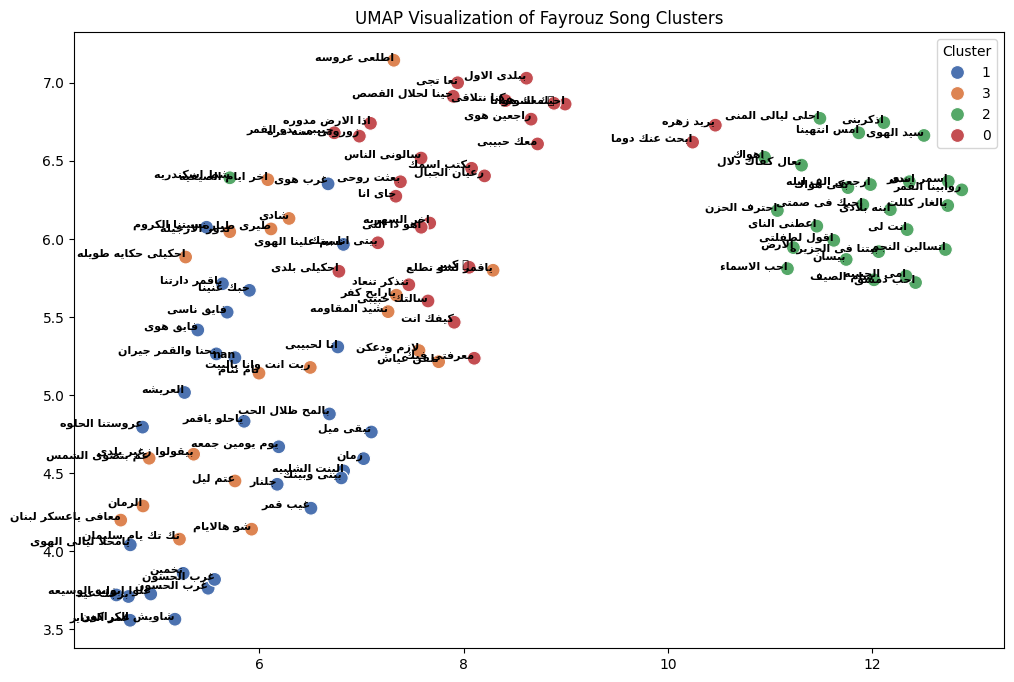

In [33]:
print("Visualizing clusters with UMAP...")

umap_embeddings = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    hue=data['Cluster'].astype(str),
    palette='deep',
    s=100
)

for i, title in enumerate(data['Track title']):
    title = str(title)
    display_title = title if len(title) <= 20 else title[:20] + '...'
    display_title = get_display(arabic_reshaper.reshape(display_title))
    plt.annotate(
        display_title,
        (umap_embeddings[i, 0], umap_embeddings[i, 1]),
        fontsize=8,
        fontweight='bold',
        ha='right'
    )

plt.title('UMAP Visualization of Fayrouz Song Clusters')
plt.savefig('umap_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


In [34]:
from transformers import pipeline
from deep_translator import GoogleTranslator
from tqdm import tqdm

emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None
)

translator = GoogleTranslator(source='ar', target='en')

def analyze_emotions_translated(lyrics):
    """
    Translates Arabic lyrics to English and predicts the dominant emotion.
    Returns the emotion label or 'neutral' in case of error or empty input.
    """
    if not isinstance(lyrics, str) or not lyrics.strip():
        return 'neutral'

    try:
        translated = translator.translate(lyrics)

        translated = ' '.join(translated.split()[:512])

        emotions = emotion_classifier(translated)[0]

        return max(emotions, key=lambda x: x['score'])['label']

    except Exception as e:
        print(f"[Error] Emotion analysis failed: {e}")
        return 'neutral'

print("Analyzing emotions...")
tqdm.pandas()
data['Emotion'] = data['Tokenized & Preprocessed Lyrics'].progress_apply(analyze_emotions_translated)
print("Emotion analysis completed.")

Device set to use cpu


Analyzing emotions...


100%|██████████| 104/104 [00:57<00:00,  1.80it/s]

Emotion analysis completed.


<ipython-input-35-5bacc0a38869>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Emotion', palette='muted')


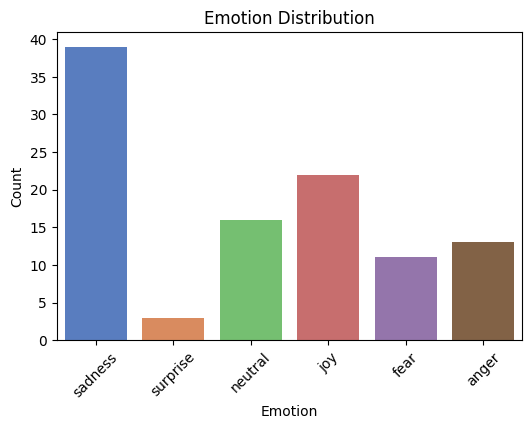

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='Emotion', palette='muted')
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

composer_texts = data.groupby('composer ')['Tokenized & Preprocessed Lyrics'] \
                     .apply(lambda lyrics: ' '.join(lyrics)) \
                     .reset_index()

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(composer_texts['Tokenized & Preprocessed Lyrics'])
terms = tfidf.get_feature_names_out()

top_n = 10

for row_idx, composer in enumerate(composer_texts['composer ']):
    scores = tfidf_matrix[row_idx].toarray().flatten()
    top_term_indices = scores.argsort()[-top_n:][::-1]
    top_terms = [terms[i] for i in top_term_indices]
    print(f"Most distinctive words for composer '{composer}': {top_terms}")

Most distinctive words for composer 'الاخوين رحبانى': ['حبيبى', 'فى', 'الهوى', 'عم', 'شو', 'انا', 'الى', 'القمر', 'تذكرونا', 'اذا']
Most distinctive words for composer 'الياس رحبانى': ['معك', 'ابقى', 'حبيبى', 'واغانى', 'دبل', 'خلصت', 'القصص', 'قمر', 'انا', 'السهر']
Most distinctive words for composer 'بيغى لى': ['بكى', 'هواك', 'ساعيش', 'مكان', 'شرودى', 'ياصديق', 'نشيدى', 'ووراء', 'هانى', 'هناء']
Most distinctive words for composer 'تراث': ['مجروحو', 'البنت', 'عيونا', 'الشلبيه', 'الخواطر', 'عينيا', 'عالبال', 'بتلوح', 'ماهان', 'القناطر']
Most distinctive words for composer 'حليم الرومى': ['اشوف', 'ومهما', 'منك', 'احبك', 'تقول', 'عنك', 'فين', 'زاد', 'واقولها', 'زمانك']
Most distinctive words for composer 'زكى ناصيف': ['امى', 'فى', 'لى', 'امل', 'وجه', 'السماء', 'اهواك', 'القلب', 'الحبيب', 'بلا']
Most distinctive words for composer 'زياد الرحبانى': ['دى', 'انا', 'هى', 'اللى', 'شو', 'شى', 'روحى', 'فى', 'كبير', 'انه']
Most distinctive words for composer 'زياد رحبانى': ['عياش', 'تلفن', 'انت', 

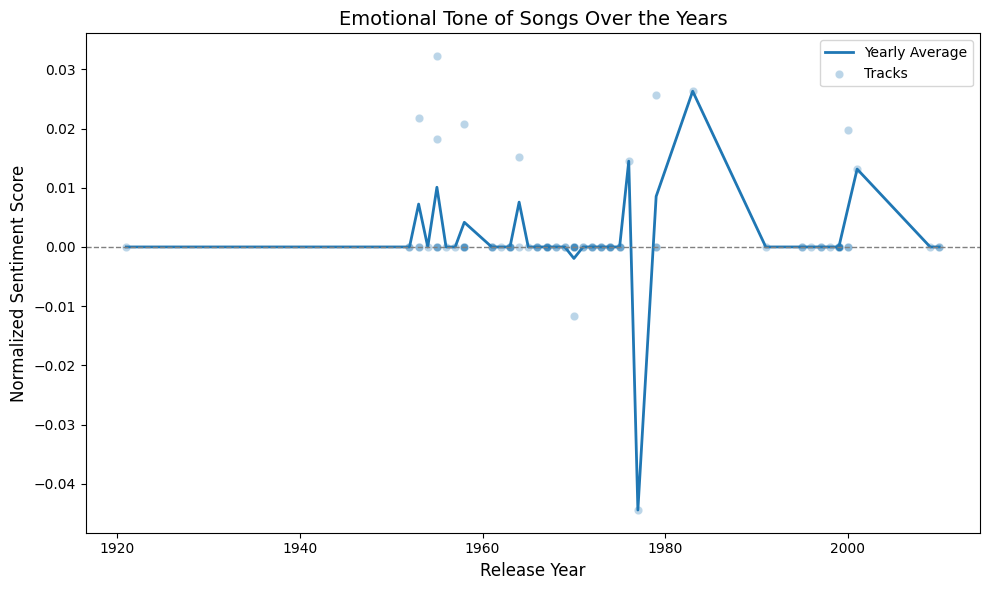

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

positive_terms = ["حب", "فرح", "جميل", "سعادة", "أمل", "سلام", "بهجة", "حنان"]
negative_terms = ["حزن", "ألم", "دموع", "كره", "خوف", "غضب", "أسى", "يأس"]

def calculate_sentiment(text):
    tokens = text.split()
    if not tokens:
        return 0
    pos_hits = sum(word in positive_terms for word in tokens)
    neg_hits = sum(word in negative_terms for word in tokens)
    return (pos_hits - neg_hits) / len(tokens)

data['Sentiment Score'] = data['Tokenized & Preprocessed Lyrics'].apply(calculate_sentiment)

avg_sentiment_by_year = (
    data.groupby('Release Year')['Sentiment Score']
    .mean()
    .reset_index()
    .sort_values('Release Year')
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_sentiment_by_year, x='Release Year', y='Sentiment Score', label='Yearly Average', linewidth=2)
sns.scatterplot(data=data, x='Release Year', y='Sentiment Score', alpha=0.3, label='Tracks')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Emotional Tone of Songs Over the Years', fontsize=14)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Normalized Sentiment Score', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

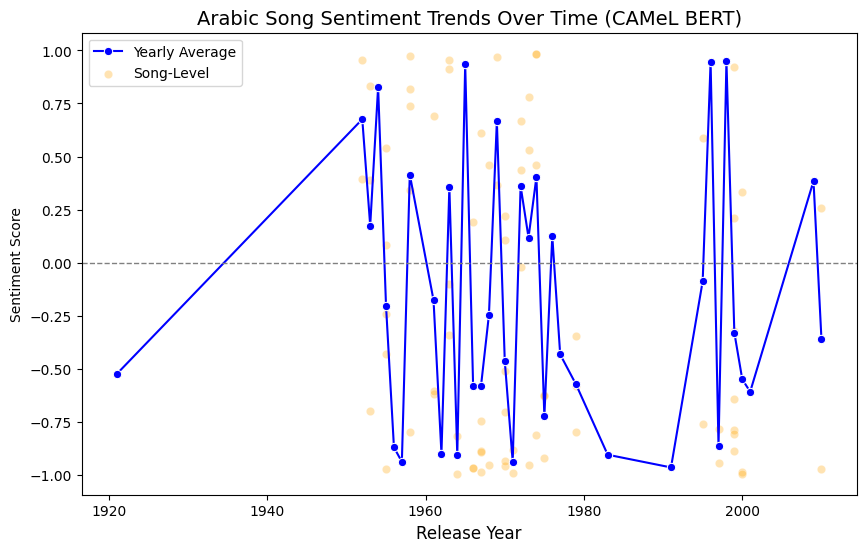

In [38]:
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

try:
    camel_sentiment = pipeline(
        task="sentiment-analysis",
        model="CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment",
        tokenizer="CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment",
        return_all_scores=True
    )
except Exception as err:
    print("Model loading failed. Ensure required libraries are installed.")
    print(f"Error details: {err}")
    raise

def extract_sentiment(text):
    if not isinstance(text, str) or text.strip() == '':
        return 0

    try:
        scores = camel_sentiment(text)[0]
        sentiment_value = 0

        for entry in scores:
            if entry['label'] == 'positive':
                sentiment_value += entry['score']
            elif entry['label'] == 'negative':
                sentiment_value -= entry['score']
        return sentiment_value  # Range: roughly -1 (negative) to +1 (positive)

    except Exception as e:
        print(f"Error scoring sentiment: {e}")
        return 0

data['Sentiment Score'] = data['Tokenized & Preprocessed Lyrics'].apply(extract_sentiment)

trend_by_year = (
    data.groupby('Release Year')['Sentiment Score']
    .mean()
    .reset_index()
    .sort_values('Release Year')
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=trend_by_year, x='Release Year', y='Sentiment Score', label='Yearly Average', color='blue', marker='o')
sns.scatterplot(data=data, x='Release Year', y='Sentiment Score', alpha=0.3, label='Song-Level', color='orange')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title('Arabic Song Sentiment Trends Over Time (CAMeL BERT)', fontsize=14)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel

In [39]:
print("Loading dataset:/content/fayrouz_lyrics_with_sentiment.csv")
try:
    data = pd.read_csv('/content/fayrouz_lyrics_with_sentiment.csv')
    print(f"Dataset loaded successfully. Total songs: {len(data)}")
except FileNotFoundError:
    print("Error: Dataset file '/content/fayrouz_lyrics_with_sentiment.csv' not found.")
    raise

Loading dataset:/content/fayrouz_lyrics_with_sentiment.csv
Dataset loaded successfully. Total songs: 104


In [40]:
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
data['Sentiment_Numeric'] = data['Sentiment'].map(sentiment_mapping)

avg_sentiment = (
    data.groupby(['Lyricist', 'composer '])['Sentiment_Numeric']
    .mean()
    .reset_index()
    .sort_values(by='Sentiment_Numeric', ascending=False) # Sort by the new numeric column
)

print(avg_sentiment.head())

avg_sentiment.to_csv('lyricist_composer_sentiment_average.csv', index=False)

            Lyricist    composer   Sentiment_Numeric
0        زياد رحباني  زياد رحبانى                1.0
7     الأخوين رحباني  زياد رحبانى                1.0
15         زكي ناصيف    زكى ناصيف                1.0
13  جبران خليل جبران    نجيب حنكش                1.0
11              تراث         تراث                1.0


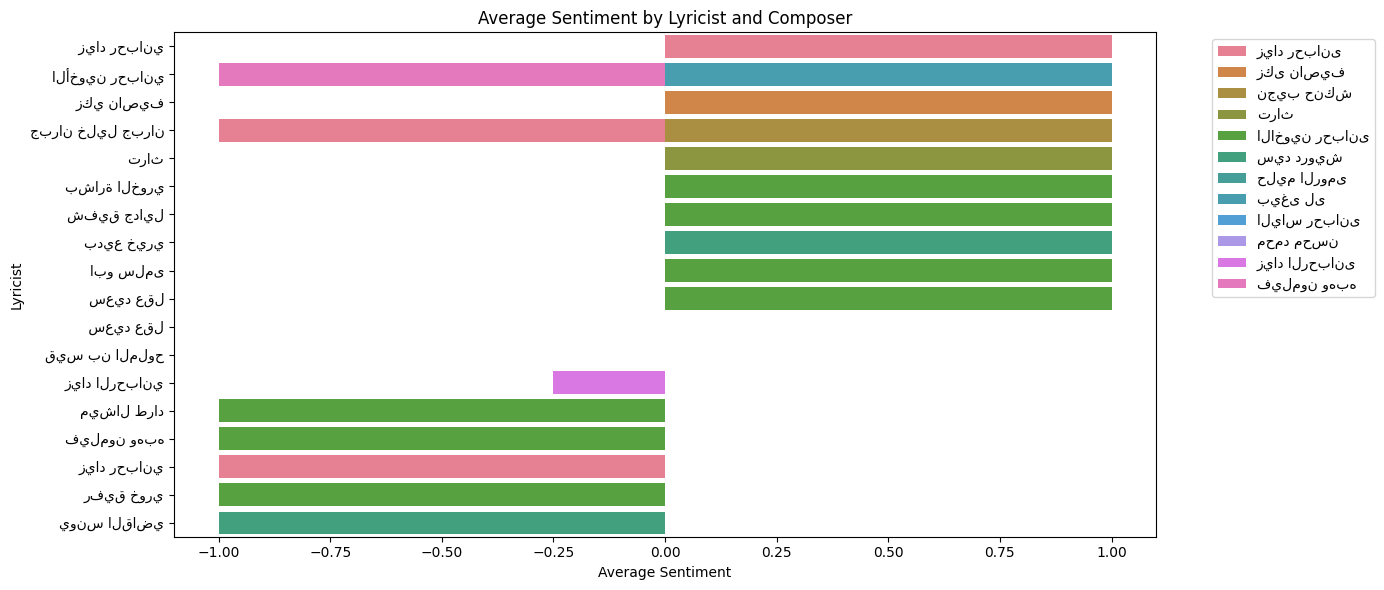

In [41]:
plt.figure(figsize=(14, 6))
sns.barplot(data=avg_sentiment, x='Sentiment_Numeric', y='Lyricist', hue='composer ', dodge=False)
plt.title('Average Sentiment by Lyricist and Composer')
plt.xlabel('Average Sentiment')
plt.ylabel('Lyricist')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


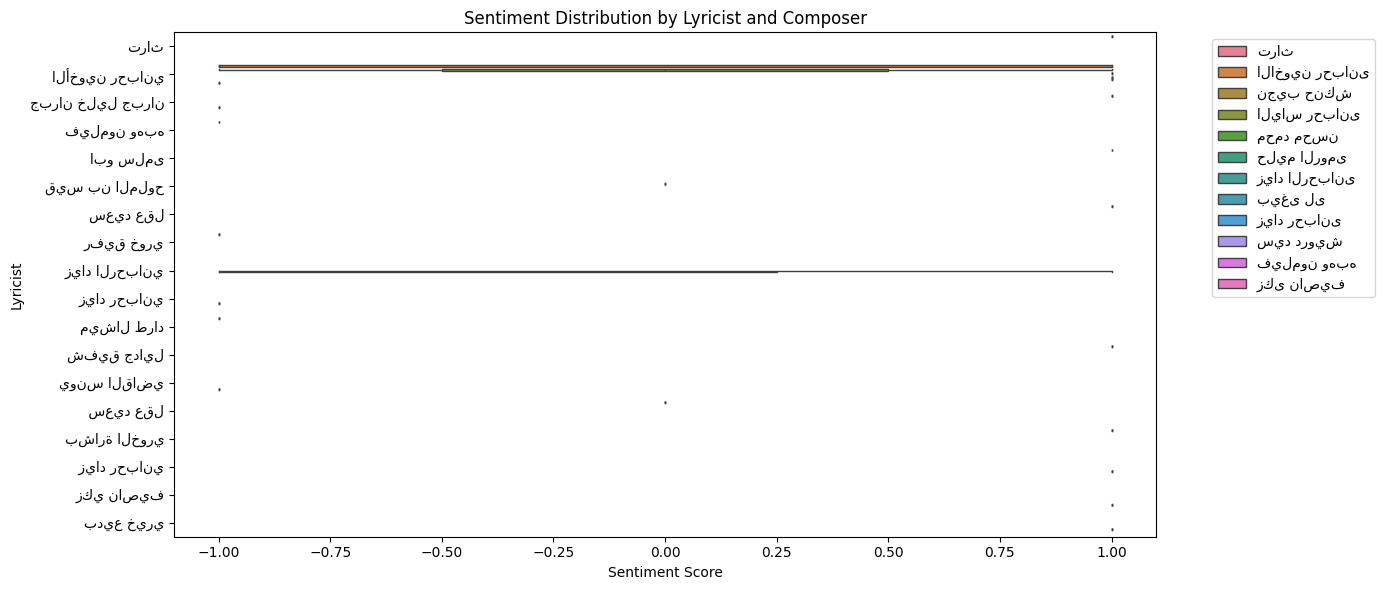

In [42]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=data, x='Sentiment_Numeric', y='Lyricist', hue='composer ')
plt.title('Sentiment Distribution by Lyricist and Composer')
plt.xlabel('Sentiment Score')
plt.ylabel('Lyricist')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

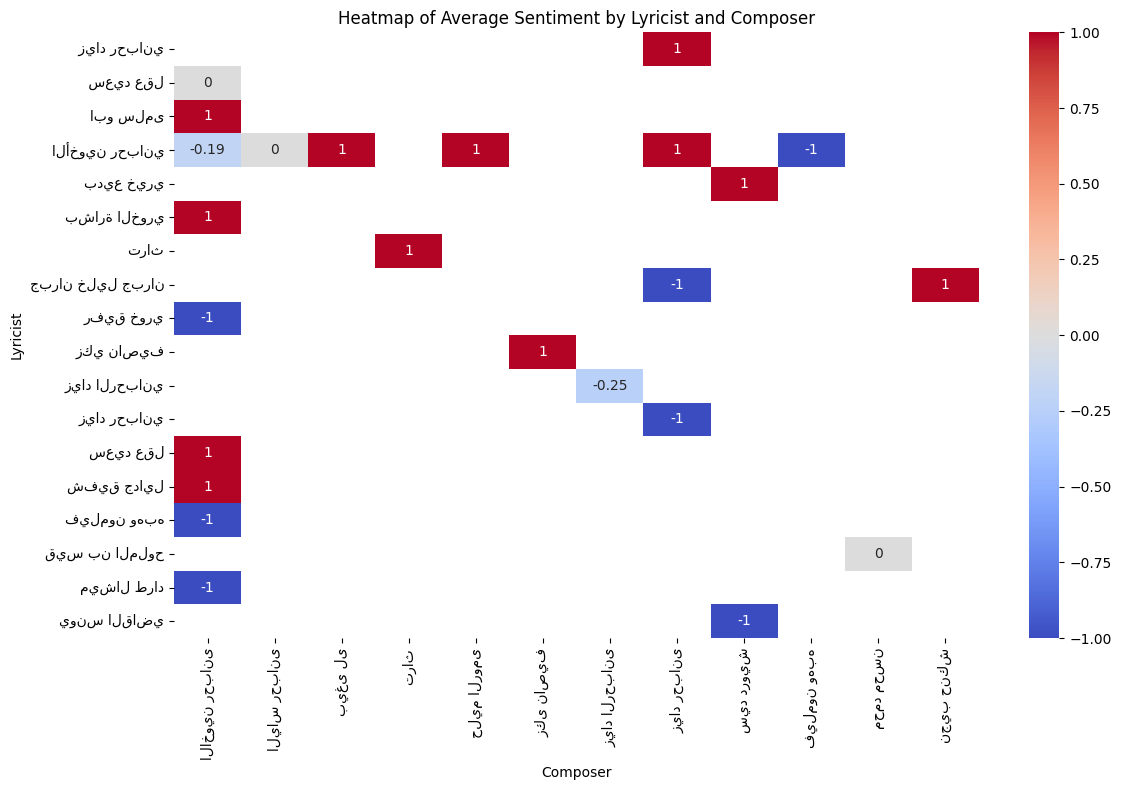

In [43]:
pivot_table = data.pivot_table(index='Lyricist', columns='composer ', values='Sentiment_Numeric', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Average Sentiment by Lyricist and Composer')
plt.xlabel('Composer')
plt.ylabel('Lyricist')
plt.tight_layout()
plt.show()

In [44]:
summary_stats = data.groupby(['Lyricist', 'composer '])['Sentiment_Numeric'].describe()
print(summary_stats)

                                 count      mean       std  min  25%  50%  \
Lyricist         composer                                                   
 زياد رحباني     زياد رحبانى       1.0  1.000000       NaN  1.0  1.0  1.0   
 سعيد عقل        الاخوين رحبانى    1.0  0.000000       NaN  0.0  0.0  0.0   
ابو سلمى         الاخوين رحبانى    1.0  1.000000       NaN  1.0  1.0  1.0   
الأخوين رحباني   الاخوين رحبانى   69.0 -0.188406  0.959095 -1.0 -1.0 -1.0   
                 الياس رحبانى      2.0  0.000000  1.414214 -1.0 -0.5  0.0   
                 بيغى لى           1.0  1.000000       NaN  1.0  1.0  1.0   
                 حليم الرومى       1.0  1.000000       NaN  1.0  1.0  1.0   
                 زياد رحبانى       1.0  1.000000       NaN  1.0  1.0  1.0   
                 فيلمون وهبه       1.0 -1.000000       NaN -1.0 -1.0 -1.0   
بديع خيري        سيد درويش         1.0  1.000000       NaN  1.0  1.0  1.0   
بشارة الخوري     الاخوين رحبانى    1.0  1.000000       NaN  1.0  1.0  1.0   

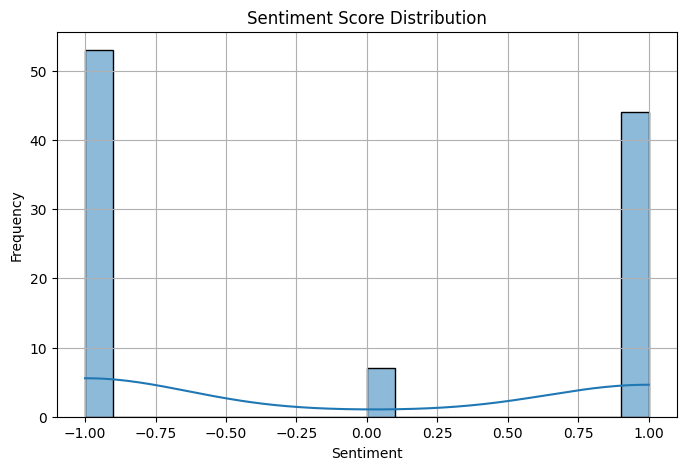

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(data['Sentiment_Numeric'], bins=20, kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

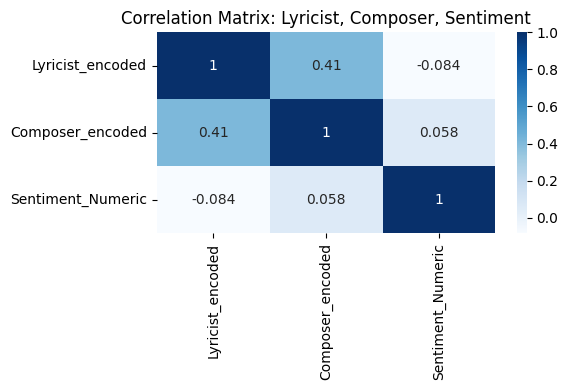

In [46]:
from sklearn.preprocessing import LabelEncoder

df_corr = data[['Lyricist', 'composer ', 'Sentiment_Numeric']].copy()
df_corr['Lyricist_encoded'] = LabelEncoder().fit_transform(df_corr['Lyricist'].astype(str))
df_corr['Composer_encoded'] = LabelEncoder().fit_transform(df_corr['composer '].astype(str))

correlation = df_corr[['Lyricist_encoded', 'Composer_encoded', 'Sentiment_Numeric']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='Blues')
plt.title('Correlation Matrix: Lyricist, Composer, Sentiment')
plt.tight_layout()
plt.show()

In [47]:
from sklearn.model_selection import train_test_split
X = data['track lyrics']
y = data['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.56      0.82      0.67        11
     neutral       0.00      0.00      0.00         1
    positive       0.60      0.33      0.43         9

    accuracy                           0.57        21
   macro avg       0.39      0.38      0.37        21
weighted avg       0.55      0.57      0.53        21



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
import joblib
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [51]:
data.head()

,Track title,track lyrics,Release Year,composer,Lyricist,Tokenized & Preprocessed Lyrics,Sentiment,Sentiment_Score,Emotion,Sentiment_Numeric
0,البنت الشلبيه,البنت الشلبيه عيونا لوزيه بحبك قلبى ياقلبى انت...,2009.0,تراث,تراث,البنت\nالشلبيه\nعيونا\nلوزيه\nبحبك\nقلبى\nياقل...,positive,0.648196,love,1
1,اخر ايام الصيفيه,اخر ايام الصيفيه والصبيه شوى شوى وصلت ساحه ميس...,1975.0,الاخوين رحبانى,الأخوين رحباني,اخر\nايام\nالصيفيه\nوالصبيه\nشوى\nشوى\nوصلت\nس...,negative,0.940842,love,-1
2,اعطنى الناى,اعطنى الناى وغن فالغنا سر الوجود وانين الناى ي...,1973.0,نجيب حنكش,جبران خليل جبران,اعطنى\nالناى\nوغن\nفالغنا\nسر\nالوجود\nوانين\n...,positive,0.591466,longing,1
3,انا لحبيبى,انا لحبيبى حبيبى الى عصفوره بيضا بقى تسالى يعت...,1965.0,الاخوين رحبانى,الأخوين رحباني,انا\nلحبيبى\nحبيبى\nالى\nعصفوره\nبيضا\nبقى\nتس...,positive,0.953652,love,1
4,بكتب اسمك,بكتب اسمك ياحبيبى الحور العتيق بتكتب اسمى حبيب...,1961.0,الاخوين رحبانى,الأخوين رحباني,بكتب\nاسمك\nياحبيبى\nالحور\nالعتيق\nبتكتب\nاسم...,negative,0.709413,love,-1


In [52]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

MODEL_NAME = "aubmindlab/aragpt2-base"
CACHE_DIR = "./custom_cache"

tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)

tokenizer.pad_token = tokenizer.eos_token

In [53]:
from transformers import TextDataset, DataCollatorForLanguageModeling

def save_lyrics_to_file(df, text_column: str, output_path: str) -> None:
    """Save lyrics from a DataFrame column to a text file, separated by double newlines."""
    with open(output_path, 'w', encoding='utf-8') as f:
        for lyrics in df[text_column]:
            if isinstance(lyrics, str) and lyrics.strip():
                f.write(lyrics.strip() + "\n\n")

def create_language_model_dataset(tokenizer, file_path: str, block_size: int = 128) -> TextDataset:
    """Create a TextDataset for language model fine-tuning."""
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )

def get_data_collator(tokenizer) -> DataCollatorForLanguageModeling:
    """Return a data collator for language modeling without masking (GPT-style)."""
    return DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )

OUTPUT_FILE = "fayrouz_lyrics.txt"
TEXT_COLUMN = "track lyrics"

save_lyrics_to_file(data, TEXT_COLUMN, OUTPUT_FILE)

train_dataset = create_language_model_dataset(tokenizer, OUTPUT_FILE)
data_collator = get_data_collator(tokenizer)

/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [54]:
import logging
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def verify_training_inputs():
    logger.info("Verifying model, dataset, and data collator...")
    required_vars = ['model', 'train_dataset', 'data_collator']
    missing = [var for var in required_vars if var not in globals()]
    if missing:
        logger.error(f"Missing required variables: {', '.join(missing)}")
        raise ValueError("Ensure model, dataset, and data collator are initialized before training.")

def prepare_dataloader(dataset, collator, batch_size):
    logger.info("Preparing DataLoader...")
    return DataLoader(dataset, batch_size=batch_size, collate_fn=collator, shuffle=True)

def setup_optimizer_scheduler(model, dataloader_len, num_epochs, learning_rate, accumulation_steps):
    logger.info("Setting up optimizer and scheduler...")
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = dataloader_len * num_epochs // accumulation_steps
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    return optimizer, scheduler

def train_model(model, dataloader, optimizer, scheduler, device, epochs, accumulation_steps):
    logger.info(f"Using device: {device}")
    model.to(device)
    model.train()

    total_steps = 0
    for epoch in range(epochs):
        logger.info(f"Epoch {epoch + 1}/{epochs}")
        for step, batch in enumerate(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss / accumulation_steps
            loss.backward()

            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                total_steps += 1
                if total_steps % 10 == 0:
                    logger.info(f"Step {total_steps}, Loss: {loss.item() * accumulation_steps:.4f}")
        logger.info(f"Completed epoch {epoch + 1}, Last batch loss: {loss.item() * accumulation_steps:.4f}")

def save_finetuned_model(model, tokenizer, output_path):
    logger.info("Saving fine-tuned model and tokenizer...")
    try:
        model.save_pretrained(output_path)
        tokenizer.save_pretrained(output_path)
        logger.info("Model and tokenizer saved successfully!")
    except Exception as e:
        logger.error(f"Failed to save model/tokenizer: {e}")
        raise

verify_training_inputs()

logger.info(f"Dataset size: {len(train_dataset)} samples")

NUM_EPOCHS = 3
BATCH_SIZE = 4
ACCUM_STEPS = 2
LEARNING_RATE = 5e-5
OUTPUT_DIR = "./fayrouz_aragpt2"

train_loader = prepare_dataloader(train_dataset, data_collator, BATCH_SIZE)
optimizer, scheduler = setup_optimizer_scheduler(model, len(train_loader), NUM_EPOCHS, LEARNING_RATE, ACCUM_STEPS)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_model(model, train_loader, optimizer, scheduler, DEVICE, NUM_EPOCHS, ACCUM_STEPS)

save_finetuned_model(model, tokenizer, OUTPUT_DIR)

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [56]:
import logging
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

NUM_EPOCHS = 5
BATCH_SIZE = 4
GRAD_ACCUM_STEPS = 2
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
WARMUP_STEPS = 100
OUTPUT_DIR = "./fayrouz_aragpt2"

def validate_environment():
    logger.info("Validating training environment...")
    required = ['model', 'train_dataset', 'data_collator']
    missing = [v for v in required if v not in globals()]
    if missing:
        logger.error(f"Missing: {', '.join(missing)}. Please run setup cells first.")
        raise ValueError("Missing required variables for training.")

def prepare_dataloader(dataset, collator):
    logger.info("Creating DataLoader...")
    return DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)

def prepare_optimizer_scheduler(model, dataloader_length):
    logger.info("Setting up optimizer and learning rate scheduler...")
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    total_steps = dataloader_length * NUM_EPOCHS // GRAD_ACCUM_STEPS
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    return optimizer, scheduler

def train(model, tokenizer, dataloader, optimizer, scheduler, device):
    logger.info(f"Training on device: {device}")
    model.to(device)
    model.train()

    total_steps = 0
    for epoch in range(NUM_EPOCHS):
        logger.info(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        total_loss = 0

        for step, batch in enumerate(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            if 'attention_mask' not in batch:
                batch['attention_mask'] = (batch['input_ids'] != tokenizer.pad_token_id).long()

            outputs = model(**batch)
            loss = outputs.loss / GRAD_ACCUM_STEPS
            total_loss += loss.item()
            loss.backward()

            if (step + 1) % GRAD_ACCUM_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                total_steps += 1

                if total_steps % 10 == 0:
                    logger.info(f"Step {total_steps}, Loss: {loss.item() * GRAD_ACCUM_STEPS:.4f}")

        avg_epoch_loss = total_loss / len(dataloader)
        logger.info(f"Epoch {epoch + 1} completed, Average Loss: {avg_epoch_loss:.4f}")

def save_model_and_tokenizer(model, tokenizer, output_path):
    logger.info("Saving fine-tuned model and tokenizer...")
    try:
        model.save_pretrained(output_path)
        tokenizer.save_pretrained(output_path)
        logger.info("Model and tokenizer saved successfully.")
    except Exception as e:
        logger.error(f"Error saving model/tokenizer: {e}")
        raise

def run_fine_tuning():
    validate_environment()
    logger.info(f"Training set size: {len(train_dataset)} samples")

    dataloader = prepare_dataloader(train_dataset, data_collator)
    optimizer, scheduler = prepare_optimizer_scheduler(model, len(dataloader))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, tokenizer, dataloader, optimizer, scheduler, device)
    save_model_and_tokenizer(model, tokenizer, OUTPUT_DIR)

run_fine_tuning()

In [60]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

model_path = "./fayrouz_aragpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_lyrics(prompt, max_length=100, num_return_sequences=1, temperature=1.0, top_k=50, top_p=0.95):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids=input_ids,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    return [tokenizer.decode(g, skip_special_tokens=True) for g in output]

# Example 2
prompt = "كان عنا طاحون"
generated = generate_lyrics(prompt, max_length=150)
print("\n".join(generated))

كان عنا طاحون طاحوا في خلنا مللنانا بظلنا طلوا عنا رحنا بتمنى عمينا تاخر فينا نضل منا رحنا رجعنا حنى بعادنا جبتنا كتير رحناها بتعودنا بقلها هسى مش دايما بنتى بسمعك بتمنلك حبيبى ناكل عنب بتحبها رحنا عم تضلنا عقبال هالولع فى حبيبى حبيبى كتير احكى ع حبيبى بحبكى حبيبى بحبكى بتمنى رحوا حبيبى وبقول حبك قلبى راحتى عللى حبيبى حبك وحكى عنكى انا حبك حبيبى وعطرنى حبيبى وانا احبك حبيبى حبيبى انا عم بتقول بحبك حبيبى حبيبى وبحبك حبيبى


In [61]:
# Example 2
prompt = "رجعت الشتوية"
generated = generate_lyrics(prompt, max_length=150)
print("\n".join(generated))

رجعت الشتوية بسا ما راح راحا الصيف صار يبدا عالرد هواك قعدنا رحنا شو بدنا بسنحنا هلق عم ناطرنا بدنا نسهر الصيف بس عنا شى رحنا ضوى عنا شو عم رح نضحك كتير هون هنينا يوا عالعندنا بدنا عالغني يللى كتير عنا هلق عا عم نضل عنا نحكي حكايا حكاك بعطر الهوى عم بيقلك رح نبقى متل كل ليله عم نحنا انا شو مشانا بدك حدا بدك رح نرجع بدى عالفاضي عنا تاكلنا بسكى بللى غنت حكينا الهوى عالاقمر بتبقى بس عم تقضلو عم بيقلى بقلك انو عم تقض
